<a href="https://colab.research.google.com/github/fouad89/transformers_tutorials/blob/main/01_transformers_in_Pytorch_and_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Emotion Detection Task
Six emotions: anger, disgust, fear, joy, sadness and surprices.

Using Distilbert

In [1]:
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 101 kB 5.8 MB/s 
     |████████████████████████████████| 596 kB 49.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 8.8 MB/s 
     |████████████████████████████████| 6.6 MB 47.8 MB/s 


In [3]:
!pip install umap-learn[plot]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 17.8 MB/s 
     |████████████████████████████████| 18.2 MB 23.3 MB/s 
     |████████████████████████████████| 76 kB 4.5 MB/s 
     |████████████████████████████████| 837 kB 52.9 MB/s 
     |████████████████████████████████| 140 kB 52.9 MB/s 
     |████████████████████████████████| 830 kB 39.0 MB/s 
     |████████████████████████████████| 822 kB 57.9 MB/s 
     |████████████████████████████████| 802 kB 59.6 MB/s 
     |████████████████████████████████| 802 kB 59.3 MB/s 
     |████████████████████████████████| 793 kB 58.9 MB/s 
     |████████████████████████████████| 793 kB 39.8 MB/s 
     |████████████████████████████████| 791 kB 40.7 MB/s 
     |████████████████████████████████| 786 kB 47.4 MB/s 
     |████████████████████████████████| 779 kB 49.4 MB/s 
     |████████████████████████████

In [4]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 5.6 MB/s 
     |████████████████████████████████| 212 kB 50.9 MB/s 
     |████████████████████████████████| 1.1 MB 45.1 MB/s 
     |████████████████████████████████| 127 kB 63.0 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 144 kB 38.9 MB/s 
     |████████████████████████████████| 271 kB 38.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [5]:
from datasets import load_dataset, list_datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import tensorflow as tf

In [6]:
# checking out the number of available datasets
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets")
print(f"The first 10 datasets are: {all_datasets[:10]}")

There are 6037 datasets
The first 10 datasets are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [7]:
# load emotions dataset 
emotions = load_dataset('emotion')

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [9]:
train_ds, val_ds, test_ds = emotions['train'], emotions['validation'], emotions['test']

In [10]:
# get column names
train_ds.column_names

['text', 'label']

In [11]:
# get data types
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [12]:
# get the first rows
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [13]:
# csv, text and json can also be loaded using
#load_dataset('csv', data_files='my_file.csv', sep='', names=[column_names])

In [14]:
# convert to dataframe
emotions.set_format(type='pandas')
train_df = emotions['train'][:]

train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [15]:
# converting labels to strings
def label_int2str(row):
    return emotions['train'].features["label"].int2str(row)


train_df['label_name'] = train_df['label'].apply(label_int2str)

In [16]:
train_df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


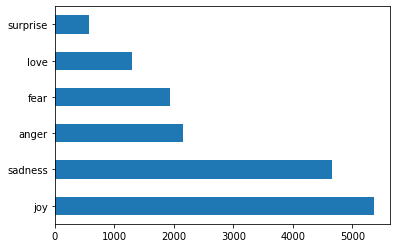

In [17]:
train_df['label_name'].value_counts().plot(kind='barh')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


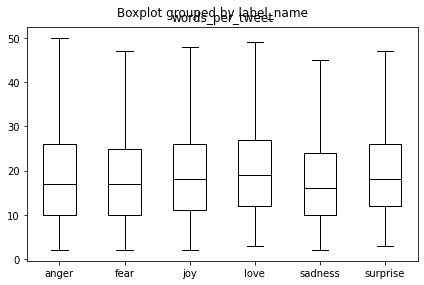

In [18]:
# tweet lengths
train_df['words_per_tweet'] = train_df['text'].str.split().apply(len)

# boxplot 
train_df.boxplot('words_per_tweet', by='label_name', grid=False, showfliers=False, color='black')
plt.xlabel('')

plt.tight_layout()

In [19]:
# convert df back to raw dataset
emotions.reset_format()

## Tokenization

In [20]:
from transformers import AutoTokenizer
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [21]:
sample_text = 'This is a test text to see the result of tokenization. The making of NLP'
print(sample_text)

This is a test text to see the result of tokenization. The making of NLP


In [22]:
encoded_text = tokenizer(sample_text)

print(encoded_text)

{'input_ids': [101, 2023, 2003, 1037, 3231, 3793, 2000, 2156, 1996, 2765, 1997, 19204, 3989, 1012, 1996, 2437, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [23]:
# identifying the tokenz
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'this', 'is', 'a', 'test', 'text', 'to', 'see', 'the', 'result', 'of', 'token', '##ization', '.', 'the', 'making', 'of', 'nl', '##p', '[SEP]']


In [24]:
# converting tokens back to text
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] this is a test text to see the result of tokenization. the making of nlp [SEP]


In [25]:
# information about tokenizer
print(f'Number of tokens in tokenizer: {tokenizer.vocab_size}')
print(f'Max Length of context size {tokenizer.model_max_length}')

print(f'Model inputs: {tokenizer.model_input_names}')

Number of tokens in tokenizer: 30522
Max Length of context size 512
Model inputs: ['input_ids', 'attention_mask']


# Tokenizing a Dataset

In [26]:
# using the map function from the DatasetDict object
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [27]:
## Tokenzing the first two sentences in the dataset
print(tokenize(emotions['train'][:2])) 

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [28]:
# special tokens
## [PAD] --ID 0
## [UNK] -- ID 100
## [CLS] -- ID 101
## [SEP] -- ID 102
## [MASK] -- ID 103

In [29]:
tokenizer?

In [30]:
# applying the tokenize to the whol dataset
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Parameter 'function'=<function tokenize at 0x7f954c8ba4d0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [31]:
# checking the column names 
emotions_encoded.column_names

{'test': ['text', 'label', 'input_ids', 'attention_mask'],
 'train': ['text', 'label', 'input_ids', 'attention_mask'],
 'validation': ['text', 'label', 'input_ids', 'attention_mask']}

In [32]:
## using pretrained models
from transformers import AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = AutoModel.from_pretrained(model_name).to(device)

cuda


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
# extracting the last hidden states
print(sample_text)
inputs = tokenizer(sample_text, return_tensors='pt')
print(f'Input tensor shape: {inputs["input_ids"].size()}') # gives [batch_size, n_tokens]

This is a test text to see the result of tokenization. The making of NLP
Input tensor shape: torch.Size([1, 20])


In [34]:
# placing into device
inputs = {k:v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)


print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.3338, -0.3289, -0.2247,  ..., -0.2365, -0.0306,  0.6055],
         [-0.4887, -0.3293, -0.2985,  ..., -0.0362,  0.4194,  0.3675],
         [-0.4137, -0.1777,  0.0921,  ...,  0.0405, -0.1687,  0.7163],
         ...,
         [-0.0196, -0.7519,  0.0925,  ..., -0.2378, -0.0953,  0.4196],
         [-0.2664, -0.4697, -0.3143,  ..., -0.0691, -0.5415,  0.1504],
         [ 0.7452, -0.0269, -0.5501,  ...,  0.1328, -0.8087, -0.1941]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [35]:
outputs.last_hidden_state.size() # [batch_size, n_tokens, hidden_dim]

torch.Size([1, 20, 768])

In [36]:
# getting hidden states for data
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    # extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # return vector for [CLS] token
    return {'hidden_state': last_hidden_state[:,0].cpu().numpy()}
    

In [37]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [38]:
# setting the format to torch
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [39]:
# extracting hidden stats
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [40]:
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

## Creating Feature Matrix

In [41]:
X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

## Visualizing the training set

In [42]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [43]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
# initializing and fitting UMAP
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
# 2d embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb['label'] = y_train
df_emb.head()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


,X,Y,label
0,4.350493,7.058023,0
1,-2.982070,6.064870,0
2,5.487590,3.560081,3
3,-2.020939,4.231488,2
4,-3.067312,4.280437,3


In [44]:
df_emb.shape

(16000, 3)

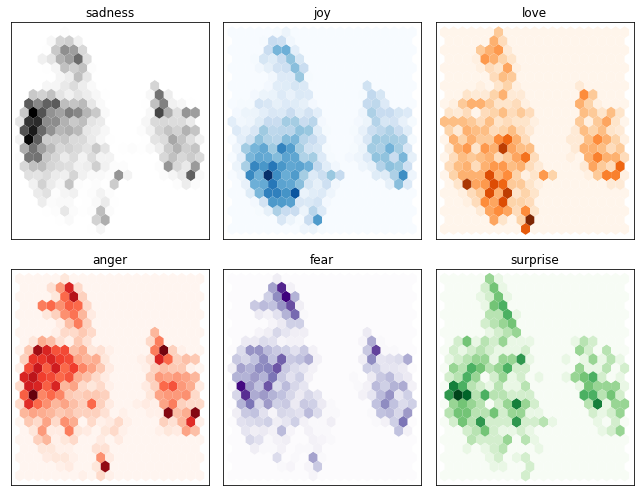

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(9,7))
axes = axes.flatten()
cmaps = ['Greys','Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f'label == {i}')
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [46]:
## Baseline
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [47]:
# Logistic Reg
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6325

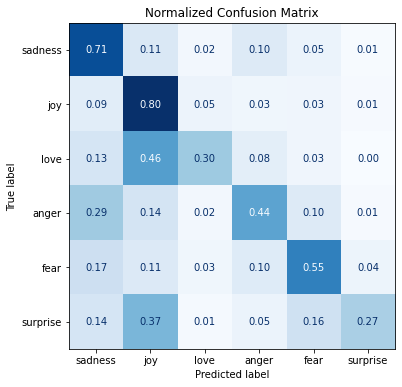

In [48]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized Confusion Matrix')
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## Fine Tuning Transformers

### PyTorch

In [49]:
# login to hugging_face hub

from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [56]:
!git config --global credential.helper store


In [57]:
#
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

In [58]:
# defining performance metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, 'f1':f1}

In [59]:
# Training Arguments
from transformers import Trainer, TrainingArguments

In [60]:
batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_n = f"{model_name}-finetuned-emotion"
training_args = TrainingArguments(
    output_dir=model_n,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error"

)

In [61]:
# instantiate the model with Trainer
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer)

trainer.train()

Cloning https://huggingface.co/fouad-shammary/distilbert-base-uncased-finetuned-emotion into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.837000,0.331729,0.901500,0.899894
2,0.256300,0.234919,0.916500,0.916411


TrainOutput(global_step=500, training_loss=0.5466371459960937, metrics={'train_runtime': 162.4889, 'train_samples_per_second': 196.937, 'train_steps_per_second': 3.077, 'total_flos': 720342861696000.0, 'train_loss': 0.5466371459960937, 'epoch': 2.0})

In [68]:
# saving and sharing the model
trainer.push_to_hub(commit_message='Training emotions model')

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Jun22_12-39-17_6083a2f6bf22/events.out.tfevents.1655901565.6083a2f6bf22.82.0:  65%|######5   …

To https://huggingface.co/fouad-shammary/distilbert-base-uncased-finetuned-emotion
   8823d66..12b0dcc  main -> main

To https://huggingface.co/fouad-shammary/distilbert-base-uncased-finetuned-emotion
   12b0dcc..68be303  main -> main



'https://huggingface.co/fouad-shammary/distilbert-base-uncased-finetuned-emotion/commit/12b0dcc2475668b3f8d47bd71c4ed5ab9f96ed29'

In [69]:
# loding the model and using it for predictions
from transformers import pipeline
model_id = 'fouad-shammary/distilbert-base-uncased-finetuned-emotion'
classifier = pipeline('text-classification', model=model_id)

Downloading:   0%|          | 0.00/883 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/695k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [71]:
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [79]:
# custom tweet example
tweet = "I hate it when my model does not work"
preds = classifier(tweet, return_all_scores=True)
print(preds)

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


[{'label': 'LABEL_0', 'score': 0.16884773969650269}, {'label': 'LABEL_1', 'score': 0.01804005727171898}, {'label': 'LABEL_2', 'score': 0.01635894738137722}, {'label': 'LABEL_3', 'score': 0.7681483030319214}, {'label': 'LABEL_4', 'score': 0.022704079747200012}, {'label': 'LABEL_5', 'score': 0.0059009031392633915}]


In [80]:
preds

[{'label': 'LABEL_0', 'score': 0.16884773969650269},
 {'label': 'LABEL_1', 'score': 0.01804005727171898},
 {'label': 'LABEL_2', 'score': 0.01635894738137722},
 {'label': 'LABEL_3', 'score': 0.7681483030319214},
 {'label': 'LABEL_4', 'score': 0.022704079747200012},
 {'label': 'LABEL_5', 'score': 0.0059009031392633915}]

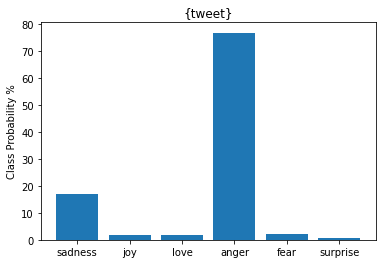

In [81]:
preds_df = pd.DataFrame(preds)
plt.bar(labels, 100*preds_df['score'], color='C0')
plt.title('{tweet}')
plt.ylabel('Class Probability %')
plt.show()

In [63]:
# get predictions for validation data
preds_output = trainer.predict(emotions_encoded['validation'])
# preds_output contains predictions, label_ids and metrics
preds_output.metrics

{'test_accuracy': 0.9165,
 'test_f1': 0.9164107076814402,
 'test_loss': 0.23491881787776947,
 'test_runtime': 3.2812,
 'test_samples_per_second': 609.531,
 'test_steps_per_second': 9.753}

In [64]:
# get the labels
preds_output.label_ids

array([0, 0, 2, ..., 1, 1, 1])

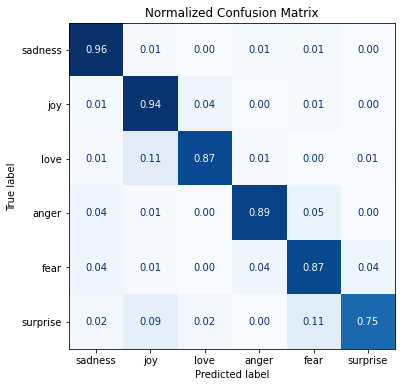

In [65]:
# predictions
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

## Fine Tuning with Tensorflow

In [66]:
from transformers import TFAutoModelForSequenceClassification
num_labels = 6
tf_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)


Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

In [67]:
# need to convert data to tfds
# column names from tokenizer
tokenizer_columns = tokenizer.model_input_names
print(tokenizer_columns)
tf_train_ds = emotions_encoded['train'].to_tf_dataset(
    columns=tokenizer_columns, label_cols=['label'], shuffle=True,

    batch_size=batch_size
)
tf_val_ds = emotions_encoded['validation'].to_tf_dataset(
    columns=tokenizer_columns, label_cols=['label'], shuffle=True,

    batch_size=batch_size
)

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy()
)
tf_model.fit(tf_train_ds,
             validation_data=tf_val_ds,
             epochs=2)

['input_ids', 'attention_mask']
Epoch 1/2
250/250 [==============================] - 102s 346ms/step - loss: 0.5222 - sparse_categorical_accuracy: 0.8207 - val_loss: 0.1877 - val_sparse_categorical_accuracy: 0.9290
Epoch 2/2
250/250 [==============================] - 84s 337ms/step - loss: 0.1389 - sparse_categorical_accuracy: 0.9412 - val_loss: 0.1452 - val_sparse_categorical_accuracy: 0.9340


## Model Validation Evaluation

In [62]:
from torch.nn.functional import cross_entropy

In [86]:
def forward_pass_with_label(batch):
    # input tensors onto device
    inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch['label'].to(device), reduction='none')
        return {'loss': loss.cpu().numpy(),
                'predicted_label': pred_label.cpu().numpy()}

In [87]:
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [88]:
emotions_encoded['test'] = emotions_encoded['test'].map(forward_pass_with_label, batched=True, batch_size=16) 

  0%|          | 0/125 [00:00<?, ?ba/s]

In [90]:
emotions_encoded.set_format('pandas')

cols = ['text', 'label', 'predicted_label', 'loss']
df_test = emotions_encoded['test'][:][cols]

df_test['labels'] = df_test['label'].map(label_int2str)
df_test['predicted_label'] = df_test['predicted_label'].map(label_int2str)

In [91]:
df_test.sort_values('loss', ascending=False)

,text,label,predicted_label,loss,labels
1382,i cannot even begin to express in words the de...,5,sadness,6.211821,surprise
290,i just feel are ludicrous and wasting space or...,5,sadness,6.180171,surprise
816,whenever i put myself in others shoes and try ...,3,joy,5.567260,anger
1533,i actually was in a meeting last week where so...,3,sadness,5.131158,anger
1613,i feel very cheated since i am supporting the ...,1,sadness,4.902778,joy
...,...,...,...,...,...
462,i don t want to tag people who think this is s...,0,sadness,0.015112,sadness
753,i am feeling a bit ungrateful and choose to co...,0,sadness,0.014992,sadness
1494,i feel like an ungrateful ass a href http this...,0,sadness,0.014694,sadness
230,i am feeling rather damaged,0,sadness,0.014501,sadness
